# Module 2: Water flow in soil

*by Daniel Leitner, Andrea Schnepf*

## Theory


In this module, we describe benchmark problems that only relate to water flow in soil. 
Water flow in soil is most commonly described by the Richards equation: 
\begin{eqnarray} \label{eq:rich1d}
\frac{\partial \theta}{\partial t}=  \nabla \cdot\left( K_c(\theta) \left( \nabla \psi_s - e_3 \right) \right),
\end{eqnarray}
in three dimesnions, where $\theta$ is the water content [1], $K_c$ is the hydraulic conductivity [cm / day], and  $\psi_s$ is the soil matric potential [cm]. 


The relationship between soil water potential and water content is generally described by the water retention curve. In the following we will use the Mualem Van Genuchten model (Van Genuchten, 1980) to describe this curve specifying the soil moisture characteristic of specific soils. 

## Benchmarks


Benchmarks for water movement in soil were developed by Vanderborght et al. (2005). In the following we will shortly describe two relevant benchmarks and implement their analytical solutions. The derivation is given by Vanderborght et al. (2005).  

In [4]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import os
import ast
from van_genuchten import *

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$ [1], $\theta_s$ [1], $\alpha$ [1/cm], $n$ [1], and $K_s$ [cm / day]:

In [5]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### Benchmark M2.2: Evaporation

For Benchmark M2.2 we consider four scenarios: (1) sand, (2) loam 1, (3) loam 2, and (4) clay, all profiles with a depth of 100 cm. Initially, we assume a soil matric potential of -40 cm for scenario (1) and -200 cm for all other soils. 

At top we prescribe an eflux of 0.1 cm/day for scenario (1) and (2), and 0.3 cm/day for (3) and (4), if the water soil potential is higher than a critical value $\psi_s(z=0)>-10000$ cm. If it is lower, we set the matric potential to the critical value with a Dirichlet boundary condition, i.e. $\psi_s(z=0) = -10000$ cm. At the bottom we assume no flux.

We are interested in the actual evaporation over time.

The analytical solution of this benchmark is calculated by the following code and reproduces Figure 5abcd from Vanderborght et al. (2005). 


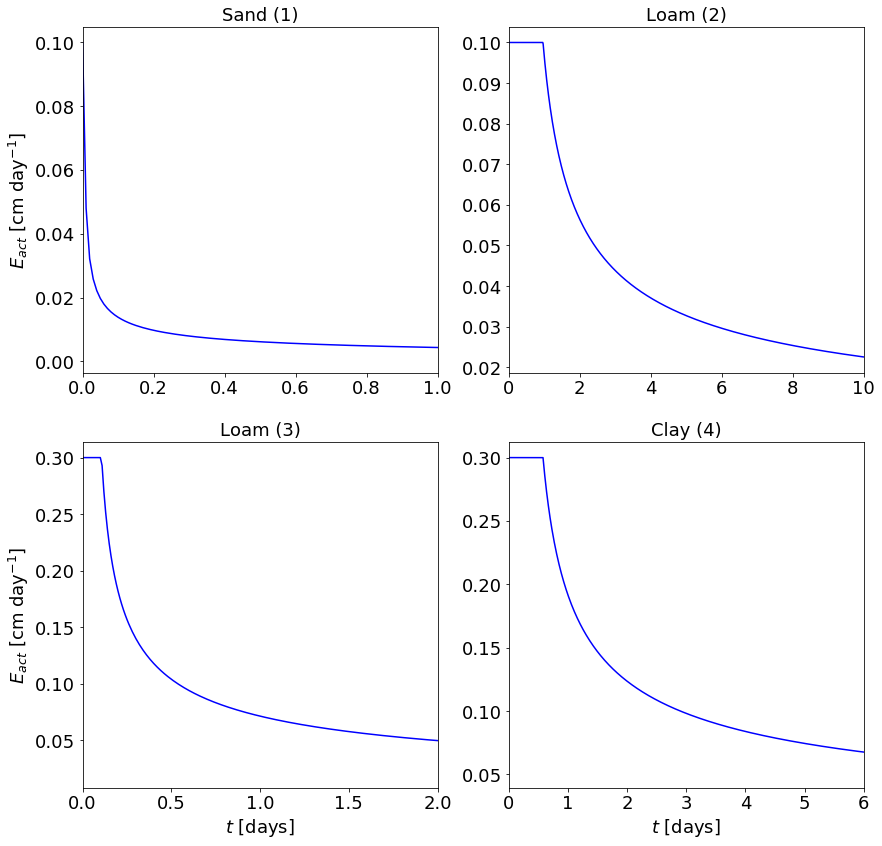

In [7]:
jwpot_ = [-0.1, -0.1, -0.3, -0.3] # potential eflux (cm/day)
head_i_ = [-40, -200, -200, -200] # initial soil matric potential (cm)

N = 1000
y = np.zeros((N,4))
t = np.linspace(0,10,N) # days

for i,soil in enumerate([sand, loam, loam, clay]):  
    
    head_i = head_i_[i]
    theta_i = water_content(head_i,soil) # initial theta  
    theta_sur = water_content(-10000,soil) # critical vaule 
    jwpot = jwpot_[i]      
    
    dw = lambda TH: water_diffusivity(TH,theta_i, theta_sur, soil)    
    int_dw, err = integrate.quad(dw,0,1)    
  
    theta_dw = lambda TH: TH*water_diffusivity(TH,theta_i, theta_sur, soil)       
    int_theta_dw, err = integrate.quad(theta_dw,0,1)
    beta = pow(int_theta_dw/int_dw,2) # Eqn 43

    fun_dw = lambda TH: pow(1-TH*beta,2)*dw(TH)
    alpha, err = integrate.quad(fun_dw,0,1)
    alpha /= int_dw  # Eqn 42

    mu = ( 3*beta*(1+np.sqrt(1-(14/9)*(1-alpha/pow(1-beta,2)) ) ) ) / ( 2*(1-beta)*(alpha/pow(1-beta,2)-1) ) # Eqb 41
    sw = lambda theta_sur, theta_i: (theta_i-theta_sur)*np.sqrt((4/mu)*int_dw) # Eqn 39  
    tdash = (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (4*jwpot*jwpot) # Eqn 44
    tpot =  (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (2*jwpot*jwpot) # Eqn 45
    jw = lambda t: (t<tpot)*jwpot+(t>=tpot)*sw(theta_sur, theta_i)/(2*np.sqrt(abs(tdash+t-tpot))) # eq 46 & 47

    y[:,i] = list(map(jw,t))  # evaluate

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))    
ax1.plot(t,abs(y[:,0]),'b')
ax1.set_ylabel('$E_{act}$ [cm day$^{-1}$]')
ax1.set_xlim(0,1)
ax1.set_title("Sand (1)")
ax2.plot(t,abs(y[:,1]),'b')
ax2.set_xlim(0,10)
ax2.set_title("Loam (2)")
ax3.plot(t,abs(y[:,2]),'b')
ax3.set_xlabel('$t$ [days]')
ax3.set_ylabel('$E_{act}$ [cm day$^{-1}$]')
ax3.set_xlim(0,2)
ax3.set_title("Loam (3)")
ax4.plot(t,abs(y[:,3]),'b')
ax4.set_xlabel('$t$ [days]')
ax4.set_xlim(0,6)
ax4.set_title("Clay (4)")
plt.show()

## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221

Van Genuchten, MT (1980) Closed-form equation for predicting the hydraulic conductivity of unsaturated soils. *Soil Science Society of America Journal* 44(5):892-898
